# Charm Analysis:

This analysis is done using `Coffea` (version 2024.10.0) and `Awkward Arrays`. This study will focus on the event selection of W+c Events.

In [20]:
import hist as h
import dask
import awkward as ak
import hist.dask as dhist
import dask_awkward as dak
import uproot
import numpy as np
import mplhep as mh
from coffea import processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from matplotlib import pyplot as plt

In [2]:
events = NanoEventsFactory.from_root(
    {"../../datasets/nano106X_on_mini106X_2017_mc_NANOAOD_W1Jets_to_LNu_250K.root": "Events"},
    schemaclass=NanoAODSchema,
).events()
events

/home/xondikoi/miniconda3/envs/Coffea/lib/python3.12/site-packages/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing cross-reference index for LowPtElectron_electronIdx => Electron
  warnings.warn(
/home/xondikoi/miniconda3/envs/Coffea/lib/python3.12/site-packages/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing cross-reference index for LowPtElectron_genPartIdx => GenPart
  warnings.warn(
/home/xondikoi/miniconda3/envs/Coffea/lib/python3.12/site-packages/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing cross-reference index for LowPtElectron_photonIdx => Photon
  warnings.warn(


dask.awkward<from-uproot, npartitions=1>

In [120]:
# Defining the style for plots (CMS Style)
plt.style.use(mh.style.CMS)
plt.rcParams.update({
    "font.size": 16,
    "axes.labelsize": 16,
    "axes.titlesize": 16,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.fontsize": 16
})

# Histogram Function:
def make_hist(data, nBins, lo, hi, xLabel, yLabel, label, fname=None, logy=False):
    histogram = dhist.Hist(h.axis.Regular(nBins, lo, hi))
    fig, ax = plt.subplots(1 ,1, figsize=(8,6))
    histogram.fill(data)
    # histogram.compute().plot(ax=ax , yerr=False, label=label)  
    mh.histplot(histogram.compute(), ax=ax, label=label, yerr=False, histtype="step") 
    mh.cms.label("Open Data", data=True, lumi=None, com=13, year=2016, loc=0)
    ax.set_xlabel(xLabel)
    ax.set_ylabel(yLabel)
    ax.legend()
    if logy:
        ax.set_yscale("log")
    if fname:
        plt.savefig(fname)
    plt.show()

In [ ]:
# Non-Coffea Processor (only-dask)
RecoMuons = events.Muon

# Muon Selection Cuts: 
Selection_Cuts = (
    (RecoMuons.pt > 35) &
    (abs(RecoMuons.eta) < 2.4) &
    ((RecoMuons.pfRelIso04_all) < 0.15) &
    (RecoMuons.tightId == 1)
)

# M_T Selection Cut:
MET = events.MET
Muon_Mt = np.sqrt(2 * RecoMuons.pt * MET.pt * (1 - np.cos(RecoMuons.phi - MET.phi)))
Selection_Cuts = Selection_Cuts & (Muon_Mt > 55)
Muons_Sel = RecoMuons[Selection_Cuts]

# Leading Muon Pt:
Sorted_Muons = Muons_Sel[dak.argsort(Muons_Sel.pt, ascending=False)]
lead_Muon_Pt = dak.firsts(Sorted_Muons.pt)
# Subleading Muon Pt:
Sub_Leading_Muons_Pad = dak.pad_none(Sorted_Muons, 2, axis=1) 
sublead_Muon_Pt = dak.fill_none(Sub_Leading_Muons_Pad[:, 1].pt, -1) 

# Number of Sorted Muons & passCuts for OS:
nMuons = dak.num(Sorted_Muons)
OS_mask = (
    (dak.num(Sorted_Muons.charge, axis=1) == 0) |
    (nMuons >= 2) |
    # (sublead_Muon_Pt > 20)
) 
Selected_Muons_PassCuts = ~OS_mask
 # Final Selection of Muons:
fMuons = Sorted_Muons[Selected_Muons_PassCuts]

In [157]:
print(sublead_Muon_Pt.compute())

[-1, -1, -1, -1, -1, -1, -1, -1, -1, ..., -1, -1, -1, -1, -1, -1, -1, -1, -1]


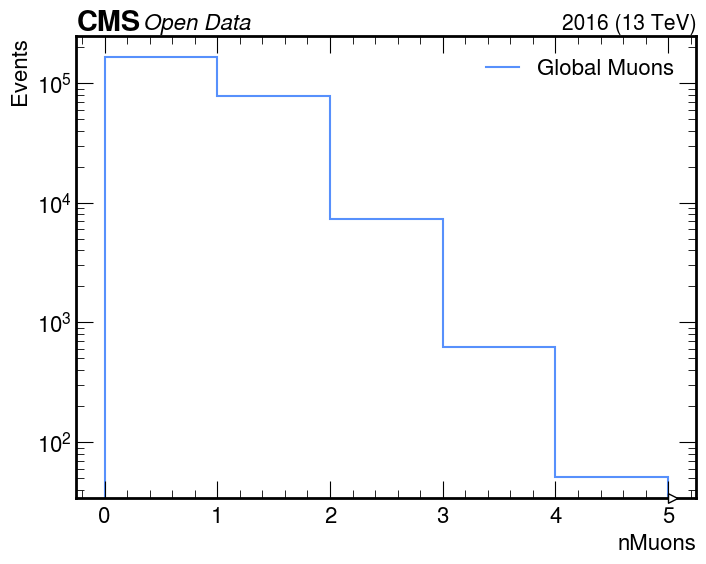

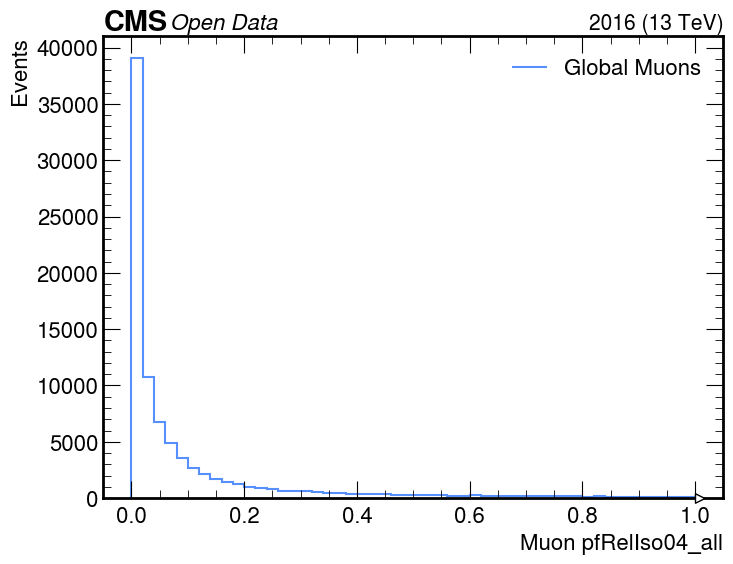

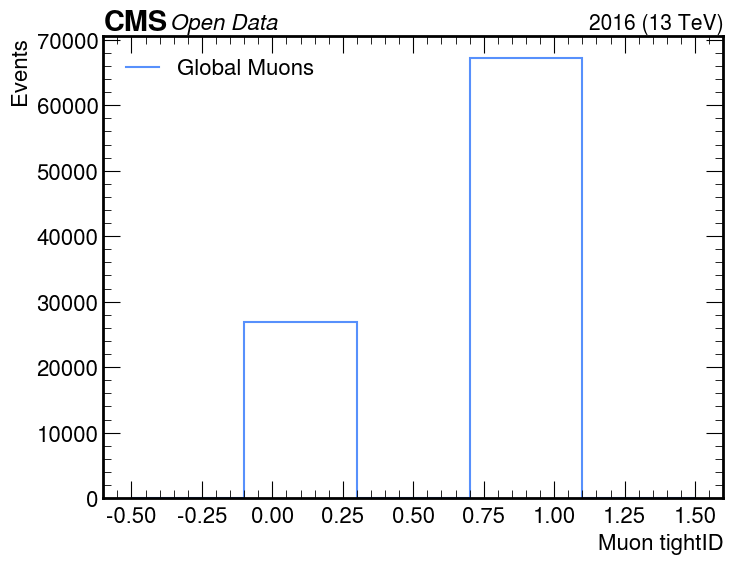

/home/xondikoi/miniconda3/envs/Coffea/lib/python3.12/site-packages/mplhep/utils.py:652: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values(), variances) - self.values())


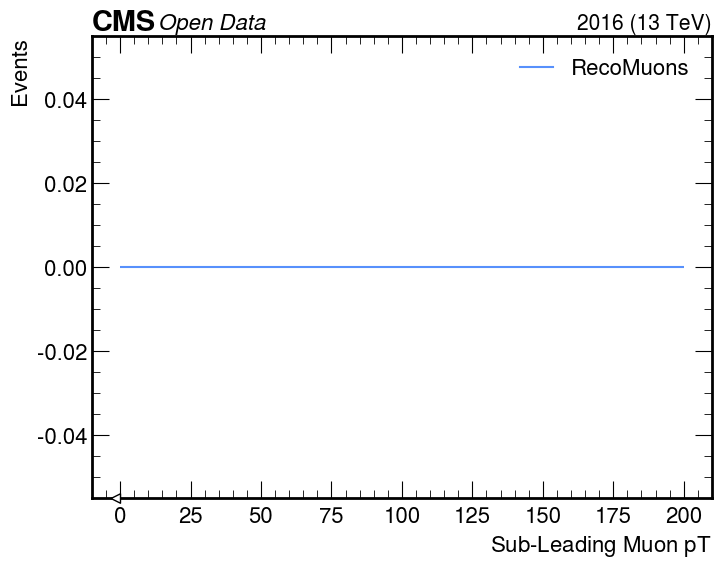

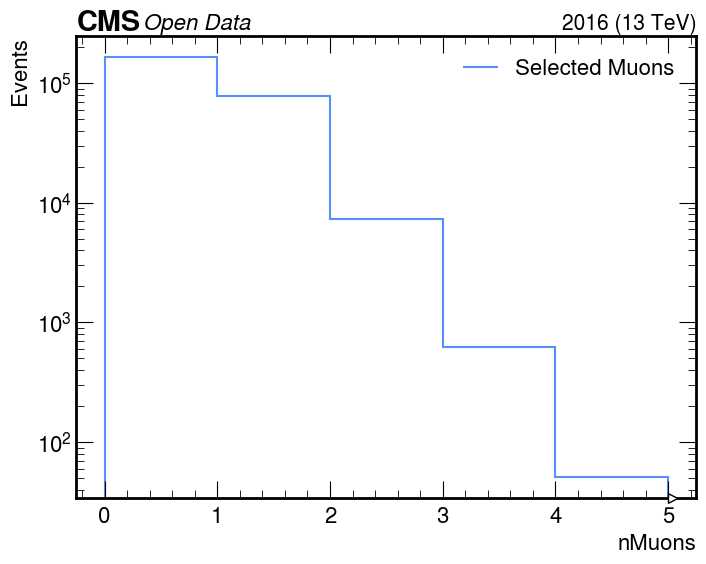

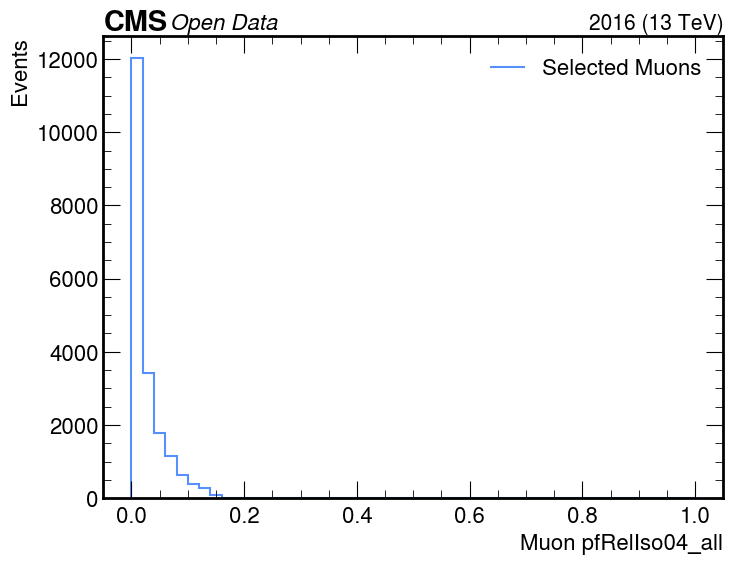

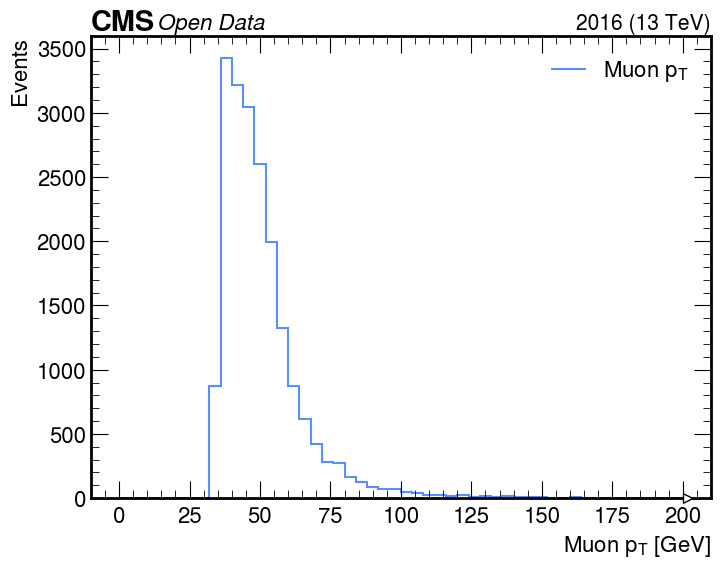

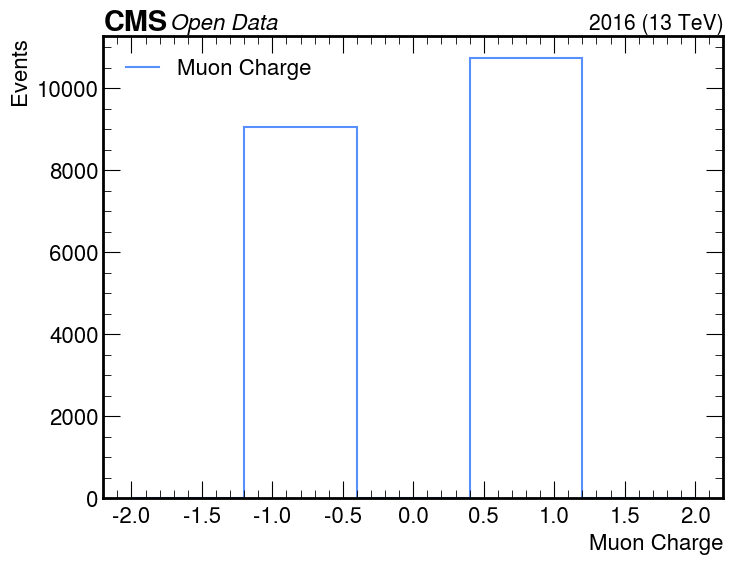

In [154]:
# Number of Global Muons:
nRecoMuons = dak.num(RecoMuons.pt)
make_hist(
    nRecoMuons,
    5, 0, 5,
    "nMuons",
    "Events",
    "Global Muons",
    fname=None,
    logy=True
)

# Global Muon pfRelIso04_all:
RecoMuon_pfRelIso04 = dak.flatten(RecoMuons.pfRelIso04_all)
make_hist(
    RecoMuon_pfRelIso04,
    50, 0, 1,
    "Muon pfRelIso04_all",
    "Events",
    "Global Muons",
    fname=None,
    logy=False
)

# Global Muon Tight ID:
RecoMuons_TightID = dak.flatten(RecoMuons.tightId)
make_hist(
    RecoMuons_TightID,
    5, -0.5, 1.5,
    "Muon tightID",
    "Events",
    "Global Muons",
    fname=None,
    logy=False
)

# Subleading Muon Pt:
passRecoMuons_SubLead_Pt = sublead_Muon_Pt
make_hist(
    passRecoMuons_SubLead_Pt,
    50, 0, 200,
    "Sub-Leading Muon $pT$",
    "Events",
    "RecoMuons",
    fname=None,
    logy=False
) 

# Number of Selected Muons:
nSel_Muons = dak.num(fMuons.pt)
make_hist(
    nRecoMuons,
    5, 0, 5,
    "nMuons",
    "Events",
    "Selected Muons",
    fname=None,
    logy=True
)

# Selected Muon PfRelIso04_all:
fMuons_pfRelIso04 = dak.flatten(fMuons.pfRelIso04_all)
make_hist(
    fMuons_pfRelIso04,
    50, 0, 1,
    "Muon pfRelIso04_all",
    "Events",
    "Selected Muons",
    fname=None,
    logy=False
)

# Selected Muon PT:
fMuons_Pt = dak.flatten(fMuons.pt)
make_hist(
    fMuons_Pt,
    50,
    0,
    200,
    "Muon $p_T$ [GeV]",
    "Events",
    "Muon $p_T$",
    fname=None,
    logy=False
)

# Selected Muon Charge:
fMuons_Charge = dak.flatten(fMuons.charge)
make_hist(
    fMuons_Charge,
    5,
    -2,
    2,
    "Muon Charge",
    "Events",
    "Muon Charge",
    fname=None,
    logy=False
)